<a href="https://colab.research.google.com/github/young-hwanlee/stand_alone_deep_learning/blob/main/%2329_Lab_Stock_Prediction_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import pandas_datareader.data as pdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy   # Add deepcopy for args
from sklearn.metrics import mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt

print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

1.12.0+cu113
Populating the interactive namespace from numpy and matplotlib


# Pandas DataReader Test

In [ ]:
# We will look at stock prices over the past year, starting at January 1, 2016.
start = (2000, 12, 1)
start = datetime.datetime(*start)
end = datetime.date.today()

print(start)
print(end)

# =============================================================
# google = pdr.DataReader(name='028050.KS', data_source='yahoo', start=start, end=end)

# ---------------------------------------------------------------------------
# RemoteDataError                           Traceback (most recent call last)
# <ipython-input-4-b4abc2ced63c> in <module>()
#       4 end = datetime.date.today()
#       5 
# ----> 6 google = pdr.DataReader(name='028050.KS', data_source='yahoo', start=start, end=end)
# =============================================================

2000-12-01 00:00:00
2022-08-12


In [ ]:
# =============================================================
pip install yfinance
# =============================================================

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 2.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
# =============================================================
import yfinance as yfin
yfin.pdr_override()

google = pdr.get_data_yahoo(tickers='028050.KS', start=start, end=end)
# =============================================================

[*********************100%***********************]  1 of 1 completed


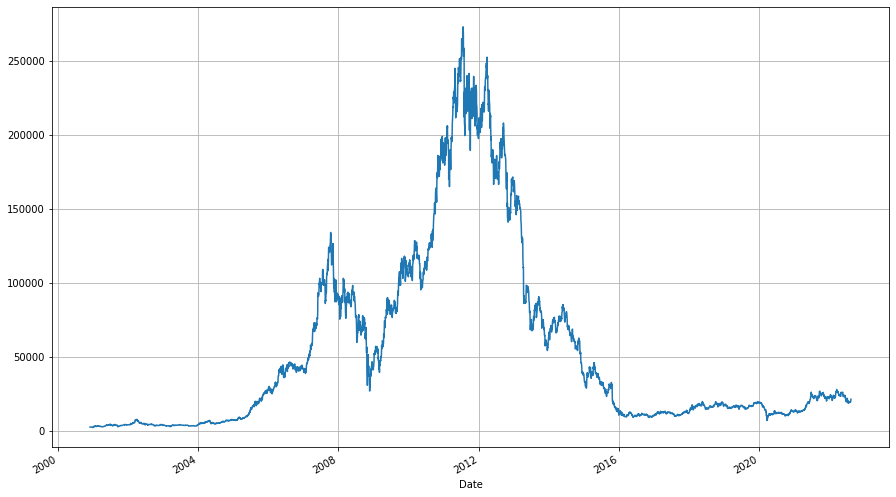

In [ ]:
google.Low.plot(grid=True)

In [ ]:
print(type(google))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
google

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-12-01,2495.0,2500.0,2420.0,2500.0,1927.813110,222800
2000-12-04,2500.0,2560.0,2450.0,2470.0,1904.679443,196100
2000-12-05,2455.0,2500.0,2455.0,2485.0,1916.245972,158800
2000-12-06,2530.0,2580.0,2490.0,2490.0,1920.102051,287600
2000-12-07,2470.0,2490.0,2455.0,2465.0,1900.823486,147900
...,...,...,...,...,...,...
2022-08-05,19600.0,20100.0,19550.0,19800.0,19800.000000,989760
2022-08-08,19750.0,20100.0,19500.0,20000.0,20000.000000,902460
2022-08-09,20050.0,20600.0,19850.0,20450.0,20450.000000,1201671


In [ ]:
google.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-05,19600.0,20100.0,19550.0,19800.0,19800.0,989760
2022-08-08,19750.0,20100.0,19500.0,20000.0,20000.0,902460
2022-08-09,20050.0,20600.0,19850.0,20450.0,20450.0,1201671
2022-08-10,20500.0,21500.0,20450.0,21100.0,21100.0,2399592
2022-08-11,21500.0,21950.0,21300.0,21400.0,21400.0,1934196


In [ ]:
print(google.isna().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


# Data Preparation

In [ ]:
num_data = 10
np.array(list(range(num_data*2)))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [ ]:
np.array(list(range(num_data*2))).reshape(-1, 2)

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11],
       [12, 13],
       [14, 15],
       [16, 17],
       [18, 19]])

In [ ]:
np.array(list(range(num_data)))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
class dummySet(Dataset):
    def __init__(self, num_data):
        self.x = np.array(list(range(num_data*2))).reshape(-1, 2)
        self.y = np.array(list(range(num_data)))
        
dataset = dummySet(100)
print(dataset.x)

[[  0   1]
 [  2   3]
 [  4   5]
 [  6   7]
 [  8   9]
 [ 10  11]
 [ 12  13]
 [ 14  15]
 [ 16  17]
 [ 18  19]
 [ 20  21]
 [ 22  23]
 [ 24  25]
 [ 26  27]
 [ 28  29]
 [ 30  31]
 [ 32  33]
 [ 34  35]
 [ 36  37]
 [ 38  39]
 [ 40  41]
 [ 42  43]
 [ 44  45]
 [ 46  47]
 [ 48  49]
 [ 50  51]
 [ 52  53]
 [ 54  55]
 [ 56  57]
 [ 58  59]
 [ 60  61]
 [ 62  63]
 [ 64  65]
 [ 66  67]
 [ 68  69]
 [ 70  71]
 [ 72  73]
 [ 74  75]
 [ 76  77]
 [ 78  79]
 [ 80  81]
 [ 82  83]
 [ 84  85]
 [ 86  87]
 [ 88  89]
 [ 90  91]
 [ 92  93]
 [ 94  95]
 [ 96  97]
 [ 98  99]
 [100 101]
 [102 103]
 [104 105]
 [106 107]
 [108 109]
 [110 111]
 [112 113]
 [114 115]
 [116 117]
 [118 119]
 [120 121]
 [122 123]
 [124 125]
 [126 127]
 [128 129]
 [130 131]
 [132 133]
 [134 135]
 [136 137]
 [138 139]
 [140 141]
 [142 143]
 [144 145]
 [146 147]
 [148 149]
 [150 151]
 [152 153]
 [154 155]
 [156 157]
 [158 159]
 [160 161]
 [162 163]
 [164 165]
 [166 167]
 [168 169]
 [170 171]
 [172 173]
 [174 175]
 [176 177]
 [178 179]
 [180 181]

In [ ]:
class dummySet(Dataset):
    def __init__(self, num_data):
        self.x = np.array(list(range(num_data*2))).reshape(-1, 2)
        self.y = np.array(list(range(num_data)))
    

    def __len__(self):
        return len(self.x)

dataset = dummySet(100)
print(len(dataset))

100


In [ ]:
class dummySet(Dataset):
    def __init__(self, num_data):
        self.x = np.array(list(range(num_data*2))).reshape(-1, 2)
        self.y = np.array(list(range(num_data)))
    

    def __len__(self):
        return len(self.x)
    

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = dummySet(100)
print(dataset[0])

(array([0, 1]), 0)


In [ ]:
dataset  = dummySet(100)
dataloader = DataLoader(dataset, 3, shuffle=False)

for batch in dataloader:
    print(batch)
    break

[tensor([[0, 1],
        [2, 3],
        [4, 5]]), tensor([0, 1, 2])]


In [ ]:
dataloader = DataLoader(dataset, 3, shuffle=True)

for batch in dataloader:
    print(batch)
    break

[tensor([[184, 185],
        [ 24,  25],
        [ 44,  45]]), tensor([92, 12, 22])]


In [ ]:
dataloader = DataLoader(dataset, 3, shuffle=True)

for batch in dataloader:
    print(batch)

[tensor([[ 30,  31],
        [122, 123],
        [ 84,  85]]), tensor([15, 61, 42])]
[tensor([[134, 135],
        [ 22,  23],
        [ 56,  57]]), tensor([67, 11, 28])]
[tensor([[ 2,  3],
        [90, 91],
        [94, 95]]), tensor([ 1, 45, 47])]
[tensor([[ 52,  53],
        [  4,   5],
        [124, 125]]), tensor([26,  2, 62])]
[tensor([[176, 177],
        [ 62,  63],
        [160, 161]]), tensor([88, 31, 80])]
[tensor([[142, 143],
        [  6,   7],
        [196, 197]]), tensor([71,  3, 98])]
[tensor([[108, 109],
        [ 18,  19],
        [ 10,  11]]), tensor([54,  9,  5])]
[tensor([[174, 175],
        [ 86,  87],
        [ 14,  15]]), tensor([87, 43,  7])]
[tensor([[ 76,  77],
        [152, 153],
        [112, 113]]), tensor([38, 76, 56])]
[tensor([[34, 35],
        [16, 17],
        [26, 27]]), tensor([17,  8, 13])]
[tensor([[148, 149],
        [ 42,  43],
        [ 44,  45]]), tensor([74, 21, 22])]
[tensor([[128, 129],
        [  0,   1],
        [118, 119]]), tensor([64,  0

In [ ]:
for X, y in dataloader:
    print(X, y)

tensor([[112, 113],
        [178, 179],
        [192, 193]]) tensor([56, 89, 96])
tensor([[ 18,  19],
        [196, 197],
        [ 76,  77]]) tensor([ 9, 98, 38])
tensor([[68, 69],
        [60, 61],
        [36, 37]]) tensor([34, 30, 18])
tensor([[132, 133],
        [182, 183],
        [130, 131]]) tensor([66, 91, 65])
tensor([[ 32,  33],
        [164, 165],
        [ 98,  99]]) tensor([16, 82, 49])
tensor([[34, 35],
        [78, 79],
        [54, 55]]) tensor([17, 39, 27])
tensor([[110, 111],
        [ 40,  41],
        [142, 143]]) tensor([55, 20, 71])
tensor([[90, 91],
        [ 6,  7],
        [74, 75]]) tensor([45,  3, 37])
tensor([[126, 127],
        [158, 159],
        [148, 149]]) tensor([63, 79, 74])
tensor([[124, 125],
        [190, 191],
        [ 26,  27]]) tensor([62, 95, 13])
tensor([[16, 17],
        [24, 25],
        [12, 13]]) tensor([ 8, 12,  6])
tensor([[150, 151],
        [102, 103],
        [162, 163]]) tensor([75, 51, 81])
tensor([[  0,   1],
        [140, 141],


In [ ]:
for X, y in dataloader:
    print(X.shape, y.shape)

torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) t

In [ ]:
dataloader = DataLoader(dataset, 3, shuffle=True, drop_last=True)

for X, y in dataloader:
    print(X.shape, y.shape)

torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) torch.Size([3])
torch.Size([3, 2]) t

In [52]:
class StockDataset(Dataset):
    def __init__(self, symbol, x_frames, y_frames, start, end):
        self.symbol = symbol
        self.x_frames = x_frames    # sequence of price fluctuations
        self.y_frames = y_frames    # price prediction from t+1 to t+x
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)

        # ==========================================================
        # self.data = pdr.DataReader(self.symbol, 'yahoo', self.start, self.end)
        # ==========================================================
        # import yfinance as yfin
        # yfin.pdr_override()
        self.data = pdr.get_data_yahoo(tickers=self.symbol, start=self.start, end=self.end)
        # ==========================================================
        print(self.data.isna().sum())


    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    

    def __getitem__(self, idx):
        idx += self.x_frames

        data = self.data.iloc[idx - self.x_frames : idx + self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Adj Close', 'Volume']]
        data = data.apply(lambda x: np.log(x+1) - np.log(x[self.x_frames-1] + 1))
        data = data.values      # data frame -> numpy array

        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [53]:
dataset = StockDataset('028050.KS', 10, 5, (2001,1,1), (2005,1,1))
print(dataset.data)

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
              Open    High     Low   Close    Adj Close   Volume
Date                                                            
2001-01-01  2300.0  2300.0  2300.0  2300.0  1773.588135        0
2001-01-02  2280.0  2490.0  2280.0  2470.0  1904.679565   570800
2001-01-03  2450.0  2450.0  2370.0  2420.0  1866.123291   366700
2001-01-04  2580.0  2740.0  2510.0  2700.0  2082.037598   816400
2001-01-05  2710.0  3105.0  2650.0  3100.0  2390.488281  2567400
...            ...     ...     ...     ...          ...      ...
2004-12-27  7400.0  7410.0  7100.0  7200.0  6000.610352   399500
2004-12-28  7150.0  7280.0  7120.0  7190.0  5992.276367   295700
2004-12-29  7100.0  7230.0  7080.0  7230.0  6242.674316   287000
2004-12-30  7160.0  7460.0  7160.0  7460.0  6441.265137   287800
2004-12-31  7460.0  7460.0  7460.0  7460.0  6441

In [54]:
dataset.data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-01,2300.0,2300.0,2300.0,2300.0,1773.588135,0
2001-01-02,2280.0,2490.0,2280.0,2470.0,1904.679565,570800
2001-01-03,2450.0,2450.0,2370.0,2420.0,1866.123291,366700
2001-01-04,2580.0,2740.0,2510.0,2700.0,2082.037598,816400
2001-01-05,2710.0,3105.0,2650.0,3100.0,2390.488281,2567400
...,...,...,...,...,...,...
2004-12-27,7400.0,7410.0,7100.0,7200.0,6000.610352,399500
2004-12-28,7150.0,7280.0,7120.0,7190.0,5992.276367,295700
2004-12-29,7100.0,7230.0,7080.0,7230.0,6242.674316,287000


In [57]:
dataset.data.iloc[0:2]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-01,2300.0,2300.0,2300.0,2300.0,1773.588135,0
2001-01-02,2280.0,2490.0,2280.0,2470.0,1904.679565,570800


In [59]:
print(type(dataset.data.iloc[0:5].values[:2]))

<class 'numpy.ndarray'>


In [60]:
dataloader = DataLoader(dataset, 2)
for X, y in dataloader:
    print(X.shape, y.shape)
    break

torch.Size([2, 10, 6]) torch.Size([2, 5, 6])


# Model Architecture

In [55]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn

        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
    

    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    

    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))

        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)

        return regressor
    

    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))

        return y_pred

In [56]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')

    return mae*100

# Train, Validate, and Test
- Data set: Give you the i-th record value.  
- Data loader: When processing data, it is required in a batch manner. DataLoader of PyTorch performs the above role.

In [61]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'],
                             batch_size=args.batch_size,
                             shuffle=True, drop_last=True)

    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_loss = 0.0
    train_acc = 0.0
    for i, (X, y) in enumerate(trainloader):
        # X: [10, n, 6] -> [sequence length = 'n' days, batch size = 10, input dimension (= no. of columns) = 6]
        # y: [10, m, 1] or [10, m]
        # where n for the past days and m for the future
        X = X.transpose(0, 1).float().to(args.device)
        y_true = y[:, :, 3].float().to(args.device)
        # print(torch.max(X[:, :, 3]), torch.max(y_true))

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]
    
    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)

    return model, train_loss, train_acc

In [71]:
def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'],
                           batch_size=args.batch_size,
                           shuffle=False, drop_last=True)
    model.eval()

    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):
            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)

    return val_loss, val_acc

In [63]:
def test(model, partition, args):
    testloader = DataLoader(partition['test'],
                            batch_size=args.batch_size,
                            shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            
            test_acc += metric(y_pred, y_true)[0]
        
    test_acc = test_acc / len(testloader)

    return test_acc

In [64]:
def experiment(partition, args):
    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)
    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ===== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ========================= #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        te = time.time()
        
        # ===== Add Epoch Data ===== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ==================== #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(model, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    
    return vars(args), result

# Manage Experiment

In [65]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
                
    df = pd.DataFrame(list_result)  # .drop(columns=[])

    return df

In [66]:
def plot_acc(var1, var2, df):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89)   # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')


    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

In [69]:
# ===== Random Seed Initialization ===== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ===== Data Loading ===== #
args.symbol = '028050.KS'
args.batch_size = 128
args.x_frames = 5
args.y_frames = 5

# ===== Model Capacity ===== #
args.input_dim = 6
args.hid_dim = 50
args.n_layers = 2

# ===== Regularization ===== #
args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

# ===== Optimizer & Training ===== #
args.optim = 'RMSprop'  # SGD, RMSprop, Adam, ...
args.lr = 0.0001
args.epoch = 2



trainset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2000,1,1), (2012,1,1))
valset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2012,1,1), (2016,1,1))
testset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2016,1,1), (2019,2,1))
partition = {'train': trainset, 'val':valset, 'test':testset}

[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [73]:
!mkdir results

In [74]:
# ===== Experiment Variable ===== #
name_var1 = 'lr'
name_var2 = 'n_layers'
list_var1 = [0.001, 0.0001, 0.00001]
list_var2 = [1, 2, 3]

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(batch_size=128, device='cuda', dropout=0.0, epoch=2, exp_name='exp1_lr', hid_dim=50, input_dim=6, l2=1e-05, lr=0.001, n_layers=1, optim='RMSprop', symbol='028050.KS', use_bn=True, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 5.90/3.63, Loss(train/val) 0.01141/0.00453. Took 11.52 sec
Epoch 1, Acc(train/val): 2.85/2.81, Loss(train/val) 0.00368/0.00330. Took 12.21 sec
Namespace(batch_size=128, device='cuda', dropout=0.0, epoch=2, exp_name='exp1_lr', hid_dim=50, input_dim=6, l2=1e-05, lr=0.001, n_layers=2, optim='RMSprop', symbol='028050.KS', use_bn=True, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 5.94/1.98, Loss(train/val) 0.01390/0.00587. Took 11.46 sec
Epoch 1, Acc(train/val): 2.56/1.95, Loss(train/val) 0.00356/0.00469. Took 11.67 sec
Namespace(batch_size=128, device='cuda', dropout=0.0, epoch=2, exp_name='exp1_lr', hid_dim=50, input_dim=6, l2=1e-05, lr=0.001, n_layers=3, optim='RMSprop', symbol='028050.KS', use_bn=True, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val

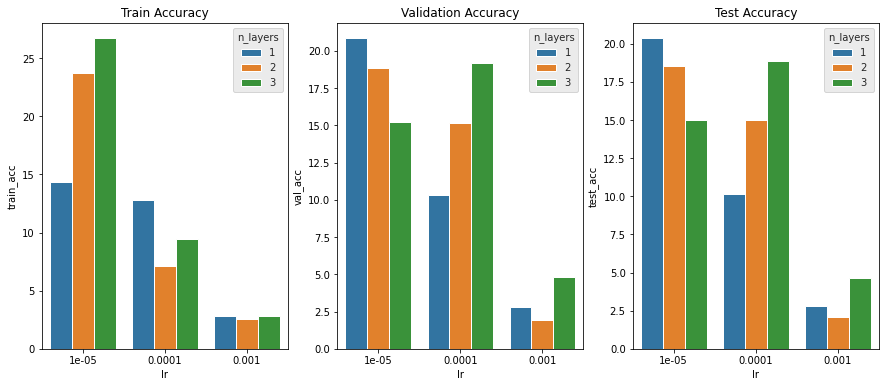

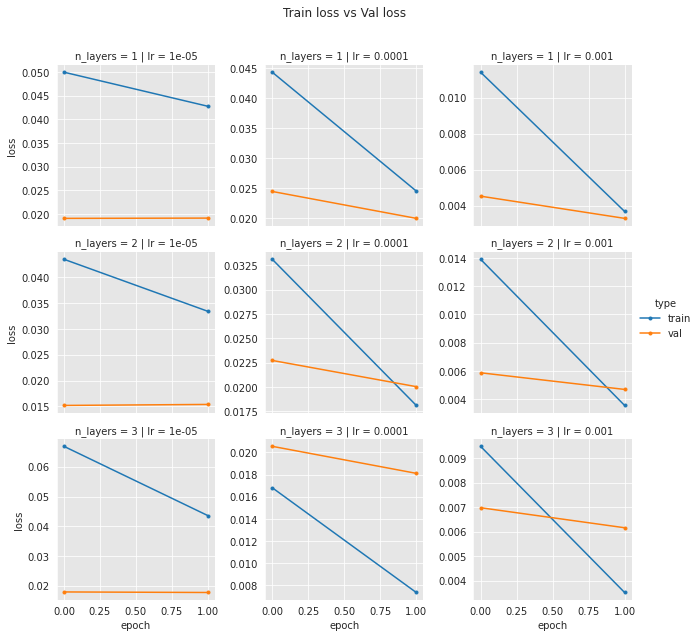

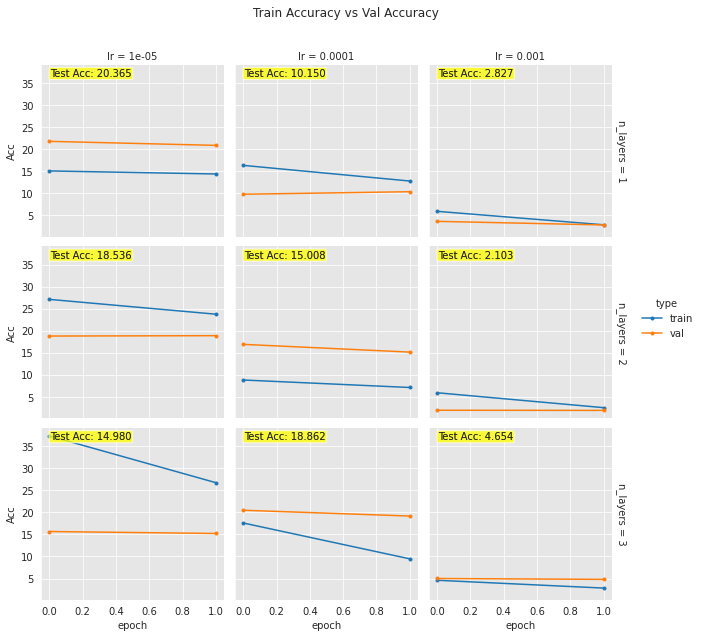

In [75]:
var1 = 'lr'
var2 = 'n_layers'
df = load_exp_result('exp1')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False)   # sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)